# TP2 - Chapter 10, exercise 10
# Adrián José Zapater Reig

Objetivo:</br>
    1- Entrenar un MLP de 2-4 capas ocultas con la API sequencial con cerca de un 98% precisión sobre el MNIST dataset.</br>
    2- Encontrar el Learning Rate óptimo.</br>

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [3]:
mnist_data = keras.datasets.mnist.load_data()

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = mnist_data

In [5]:
y_train_full.shape

(60000,)

In [6]:
y_test.shape

(10000,)

## Primero separamos el validation set del training set y escalamos cada pixel al rango 0-1.
Puesto que cada pixel toma un valor entre 0 y 255, vamos a dividir por 255. Dividimos por 255 como float (con el '.') para que el resultado. también tenga decimales.

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

## Tenemos 60000 imágenes en matrices de 28x28.

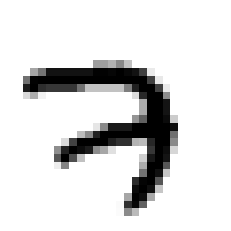

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [9]:
# Tenemos 10 clases distintas, una por cada número del 0 al 9.
y_train[0]

7

# Intento 1 - 4 capas ocultas
Vamos a intentar resolver el problema con una única MLP de 4 capas ocultas usando la Sequential API.

Como se trata de un problema de Multiclass classification con matrices de 28x28 usaremos:
- 28x28 = 784 input neurons
- 4 capas opcultas
- Neuronas por capa: 300
- 10 output neurons (una por clase)
- Función de activación de las capas ocultas: ReLU
- Función de activación de la output layer: Softmax
- Loss Function: Cross Entropy

In [10]:
hidden_neurons = 300
class_num = 10

model1 = keras.models.Sequential()
model1.add(keras.layers.Flatten(input_shape=[28, 28]))
model1.add(keras.layers.Dense(hidden_neurons, activation=keras.activations.relu))
model1.add(keras.layers.Dense(hidden_neurons, activation=keras.activations.relu))
model1.add(keras.layers.Dense(hidden_neurons, activation=keras.activations.relu))
model1.add(keras.layers.Dense(hidden_neurons, activation=keras.activations.relu))
model1.add(keras.layers.Dense(class_num, activation=keras.activations.softmax))

In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3010      
Total params: 509,410
Trainable params: 509,410
Non-trainable params: 0
__________________________________________________

## Compilamos el modelo.

In [12]:
model1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

## Entrenamos el modelo.
Vamos a implementar Early Stopping y guardar el modelo con mejor rendimiento.
También vamos a usar el callback de TensorBoard que propociona Keras para visualizar la curva de aprendizaje.

In [13]:
# Creamos un método que genere carpetas parametrizado por la fecha. Esto lo usará TB para giardar los logs de cada run en una carpeta distinta.
import os

root_logdir = os.path.join(os.curdir, "tb_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [14]:
# Para solucionar un problema en OSX:
# Error: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [15]:
# TB callback
tb_cb = keras.callbacks.TensorBoard(get_run_logdir())

In [16]:
# Checkpoint callback para guardar el estado de los modelos en cada epoch.
# Guardamos sólo el mejor para ahorrar espacio.
ck_cb = keras.callbacks.ModelCheckpoint("intento1_model.h5", save_best_only=True)

In [17]:
# Early Stop callback. Lo parametrizamos con 15 epoch de paciencia.
es_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [18]:
# Finalmente entrenamos el modelo.
history = model1.fit( X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[tb_cb, ck_cb, es_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 11s 195us/sample - loss: 0.6675 - sparse_categorical_accuracy: 0.8268 - val_loss: 0.2739 - val_sparse_categorical_accuracy: 0.9246
Epoch 2/100
55000/55000 [==============================] - 10s 183us/sample - loss: 0.2513 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.2335 - val_sparse_categorical_accuracy: 0.9298
Epoch 3/100
55000/55000 [==============================] - 9s 168us/sample - loss: 0.1893 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1546 - val_sparse_categorical_accuracy: 0.9536
Epoch 4/100
55000/55000 [==============================] - 9s 166us/sample - loss: 0.1521 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.1411 - val_sparse_categorical_accuracy: 0.9564
Epoch 5/100
55000/55000 [==============================] - 9s 166us/sample - loss: 0.1264 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.1127 - val_sparse_categorical_accuracy: 0.9678
Epoc

In [19]:
import pandas as pd

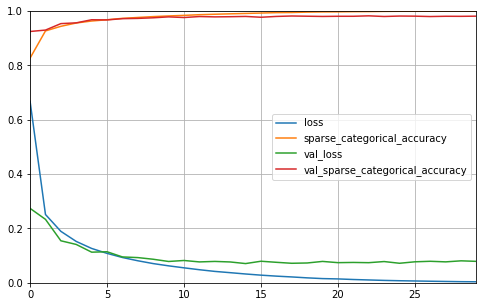

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
# Usamos la extensión de TB.
%load_ext tensorboard
%tensorboard --logdir=./tb_logs --port=6008

Reusing TensorBoard on port 6008 (pid 5058), started 0:05:29 ago. (Use '!kill 5058' to kill it.)

Aunque tenemos una accuracy > 98% vamos a hacer hyperparameter tunning.

## Hyperparameter Tunning
Vamos a hcer un wrapper para nuestro modelo y que así podamos usar el RandomzedSearchCV.

In [24]:
def build_model(n_hidden=1, n_neurons=300, learning_rate=3e-3, input_shape=[28, 28], out_neurons=10):
    model = keras.models.Sequential()
    # Input Layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=keras.activations.relu))
    # Output Layer
    model.add(keras.layers.Dense(out_neurons, activation=keras.activations.softmax))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy, 
        optimizer=optimizer, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    
    return model

In [25]:
keras_wrapper = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [26]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    # Ya hemos probado el modelo con 4.
    "n_hidden": [0, 1, 2, 3, 4],
    # Probamos de 50 en 50.
    "n_neurons": np.arange(50, 400, 50),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_wrapper, param_distribs, n_iter=5, cv=3, verbose=0)

In [27]:
# Bajamos el número de epochs de patience para que no se alargue el entrenamiento.
es_cb_unpatient = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

In [27]:
opt_ck_cb = keras.callbacks.ModelCheckpoint("opt_model.h5", save_best_only=True)

In [ ]:
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[es_cb_unpatient, tb_cb, opt_ck_cb])

In [ ]:
rnd_search_cv.best_params_

## Re-entrenamos con los parámetros óptimos

In [ ]:
hidden_layers = 4
hidden_neurons = 300
class_num = 10
LR = 0.01

In [ ]:
model_opt = build_model(n_hidden=hidden_layers, n_neurons=hidden_neurons, learning_rate=LR, out_neurons=class_num, input_shape=[28, 28])

In [ ]:
model_opt.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=LR),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [ ]:
history_opt = model_opt.fit( X_train, y_train, epochs=150, validation_data=(X_valid, y_valid), callbacks=[tb_cb, opt_ck_cb, es_cb])

Volvemos a ver las gráficas de TB.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./tb_logs --port=6008

## Evaluamos los modelos:

In [22]:
# Modelo con 4 capas:
model1.evaluate(X_test, y_test)
# [0.07861688811050262, 0.9761]

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.07861688811050262, 0.9761]

In [ ]:
# Modelo optimizado:
model_opt.evaluate(X_test, y_test)